In [1]:
# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1, as_frame=False) # as_frame이 True일 경우 DataFrame 타입으로 변환됨 -> 오류
mnist.keys()

#사이킷런에서 읽어 들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 갖고 있음
#1 데이터셋을 설명하는 DESCR키
#2 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data키
#3 레이블 배열을 담은 target 키

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
#배열 살펴보기

X, y = mnist["data"], mnist["target"]

In [4]:
X.shape

#이미지 = 70000개, 각 이미지에 784개의 특성(28 * 28)

(70000, 784)

In [5]:
y.shape

(70000,)

그림 저장: some_digit_plot


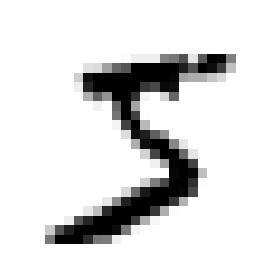

In [6]:
#데이터셋에서 이미지 확인

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [7]:
#실제 레이블

y[0]

'5'

In [8]:
#레이블이 문자열이기 때문에 편의를 위해 정수로 변환함

y = y.astype(np.uint8)

In [9]:
#훈련 세트, 테스트 세트 분리하기
#MNIST 뎅터셋은 앞쪽 60000개(훈련), 뒤쪽 100000개(테스트) 이미지로 나눠져있음

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#데이터셋을 섞어 알고리즘의 성능을 더욱 좋게할 수 있음(위 훈련세트는 이미 섞여있음)

In [10]:
#이진 분류기 훈련

#숫자 5 식별하기
#5-감지기 (5와 5아님으로 분류)

#분류 작업을 위한 타깃 벡터 생성

y_train_5 = (y_train == 5) #5 이외 모두 false, 5는 true
y_test_5 = (y_test == 5)

In [11]:
#확률적 경사 하강법 분류기로 훈련시키기

#SGDClassifier = 매우 큰 데이터셋을 효율적으로 처리(한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) #훈련하는데 무작위성을 사용하기 때문에 결과 재현을 위해 random_state 매개변수 지정
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
#위의 모델을 사용해 숫자 5 감지하기

sgd_clf.predict([some_digit])

#5를 나타낸다고 추측함(결과가 True)

array([ True])

In [13]:
#모델 성능 평가하기

#①교차 검증

#StratifiedKFold를 활용한 교차 검증 구현하기
#사이킷런의 cross_val_score()과 거의 같은 작업 수행, 동일한 결과 출력하는 코드

#StratifiedKFold = target에 속성값의 개수를 동일하게 가져감으로써 데이터가 한 곳으로 몰리는 것을 방지

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) #매 반복에서 분류기 객체 복제
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds) #훈련 폴드로 훈련
    y_pred = clone_clf.predict(X_test_fold) #테스트 폴드로 예측
    n_correct = sum(y_pred == y_test_fold) #정확히 예측된 경우
    print(n_correct / len(y_pred)) #정확한 예측의 비율 출력

0.9669
0.91625
0.96785


In [14]:
#k-겹 교차 검증을 사용해 SGDClassifier 모델 평가

from sklearn.model_selection import cross_val_score

#3개의 폴드로 나누고(cv=3) 훈련시킨 후 모델의 정확도 점수 구하기
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [15]:
#모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기 생성

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

#불균형한 데이터셋을 다룰 때 결과값이 달라지기 때문에 정확도를 분류기의 성능 측정 지표로 선호하지 않음

array([0.91125, 0.90855, 0.90915])

In [17]:
#②오차 행렬
#클래스 A의 샘플이 클래스 B로 분류된 횟수 세기

#실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 함
#테스트세트는 프로젝트의 맨 마지막에 사용되는 것이기 때문에 예측을 만들 때 사용하면 안됨

#cross_val_predict() = 예측값 구하기

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
#오차 행렬 만들기

# 5, 5아님 2*2 행렬 생성됨

#

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [21]:
#완벽한 오차 행렬의 예

y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)